<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_GoogleNet_Exp1_CHUK_DUT_SZU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
from PIL import Image
from tensorflow import keras
from keras.models import Sequential, Model,load_model
from keras import layers
from keras import regularizers
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Concatenate
from keras import regularizers

In [10]:
!unzip -qq BlurDatasetImage.zip

In [11]:
!unzip -qq BlurDatasetGT.zip

In [12]:
from numpy import *
images_folder= "image/*"
labels_folder = "gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      # image resize
      image = Image.open(myFile)
      image = image.resize((224, 224))
      image = np.asarray(image)
      total_img.append(image)
      #Gt
      image_name=image_name[:-3]
      image_name=image_name+'png'
      label_image = Image.open(labels_folder+image_name)
      label_image = label_image.resize((224, 224))
      label_image = np.asarray(label_image)
      if (label_image.shape!=(224,224)):
        label_image=label_image[:,:,0]
      label.append (label_image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]]) 
  return label,total_img

In [13]:
total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [14]:
total_images.shape

(1000, 224, 224, 3)

In [15]:
total_labels.shape

(1000, 224, 224)

In [16]:
def inception(x, filters):
    # 1x1
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    # 1x1->3x3
    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    # 1x1->5x5
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    # 3x3->1x1
    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])

In [17]:
def ident_auxiliary(x,name=None):
  dec3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)#28*28*512
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same")(dec7)#224*224*1
  #FusionNetwork
  Upsam_Deep = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Deep,Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same")(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_Shallow])
  Axilary_final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005),name=name)(concatted_all) #224*224*1
  return Axilary_final_output

In [18]:
def identifier(x,name=None):
  dec2 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x) #14*14*512
  dec3 = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(dec2)#28*28*256
  dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
  dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
  dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
  dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu",padding="same")(dec6)#224*224*1
  dec8 = layers.Conv2DTranspose(1, (3, 3), strides=1, activation="relu",padding="same")(dec7)#224*224*1
  #FusionNetwork1
  Upsam_Deep1 = layers.Conv2DTranspose(128, (3, 3), strides=32, activation="relu", padding="same")(x)
  Upsam_Deep2 = layers.Conv2DTranspose(128, (3, 3), strides=16, activation="relu", padding="same")(dec2)
  Upsam_Deep3 = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
  concatted_deep = tf.keras.layers.Concatenate(axis=3)([Upsam_Deep1,Upsam_Deep2,Upsam_Deep3])
  result_concatted_deep= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same")(concatted_deep) #224*224*1
  #FusionNetwork2
  Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
  Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
  concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Shallow1,Upsam_Shallow2,dec6])
  result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="relu", padding="same",)(concatted_Shallow) #224*224*1
  #Concatenate all results
  concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_deep,result_concatted_Shallow])
  final_output= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid",name=name, padding="same",kernel_regularizer=regularizers.L2(l2=0.005),
      bias_regularizer=regularizers.L2(l2=0.0005))(concatted_all) #224*224*1
  return final_output


In [19]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [20]:
def googlenet():
  layer_in = Input(shape=(224, 224, 3))  
  # stage-1
  layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  layer = BatchNormalization()(layer)
  # stage-2
  layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
  layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
  layer = BatchNormalization()(layer)
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-3
  layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
  layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-4
  layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
  ident1  = ident_auxiliary(layer, name='ident1')
  #aux1  = auxiliary(layer, name='aux1')
  layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
  layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
  layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
  ident2 =ident_auxiliary(layer, name='ident2')
  #aux2  = auxiliary(layer, name='aux2')
  layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
  layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
  # stage-5
  layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
  layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
  ident  = identifier(layer, name='ident')
  #layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
  # stage-6
  #layer = Flatten()(layer)
  #layer = Dropout(0.4)(layer)
  #layer = Dense(units=256, activation='linear')(layer)
  #main = Dense(units=1, activation='sigmoid', name='main')(layer)  
  model = Model(inputs=layer_in, outputs=[ident,ident1,ident2]) 
  return model

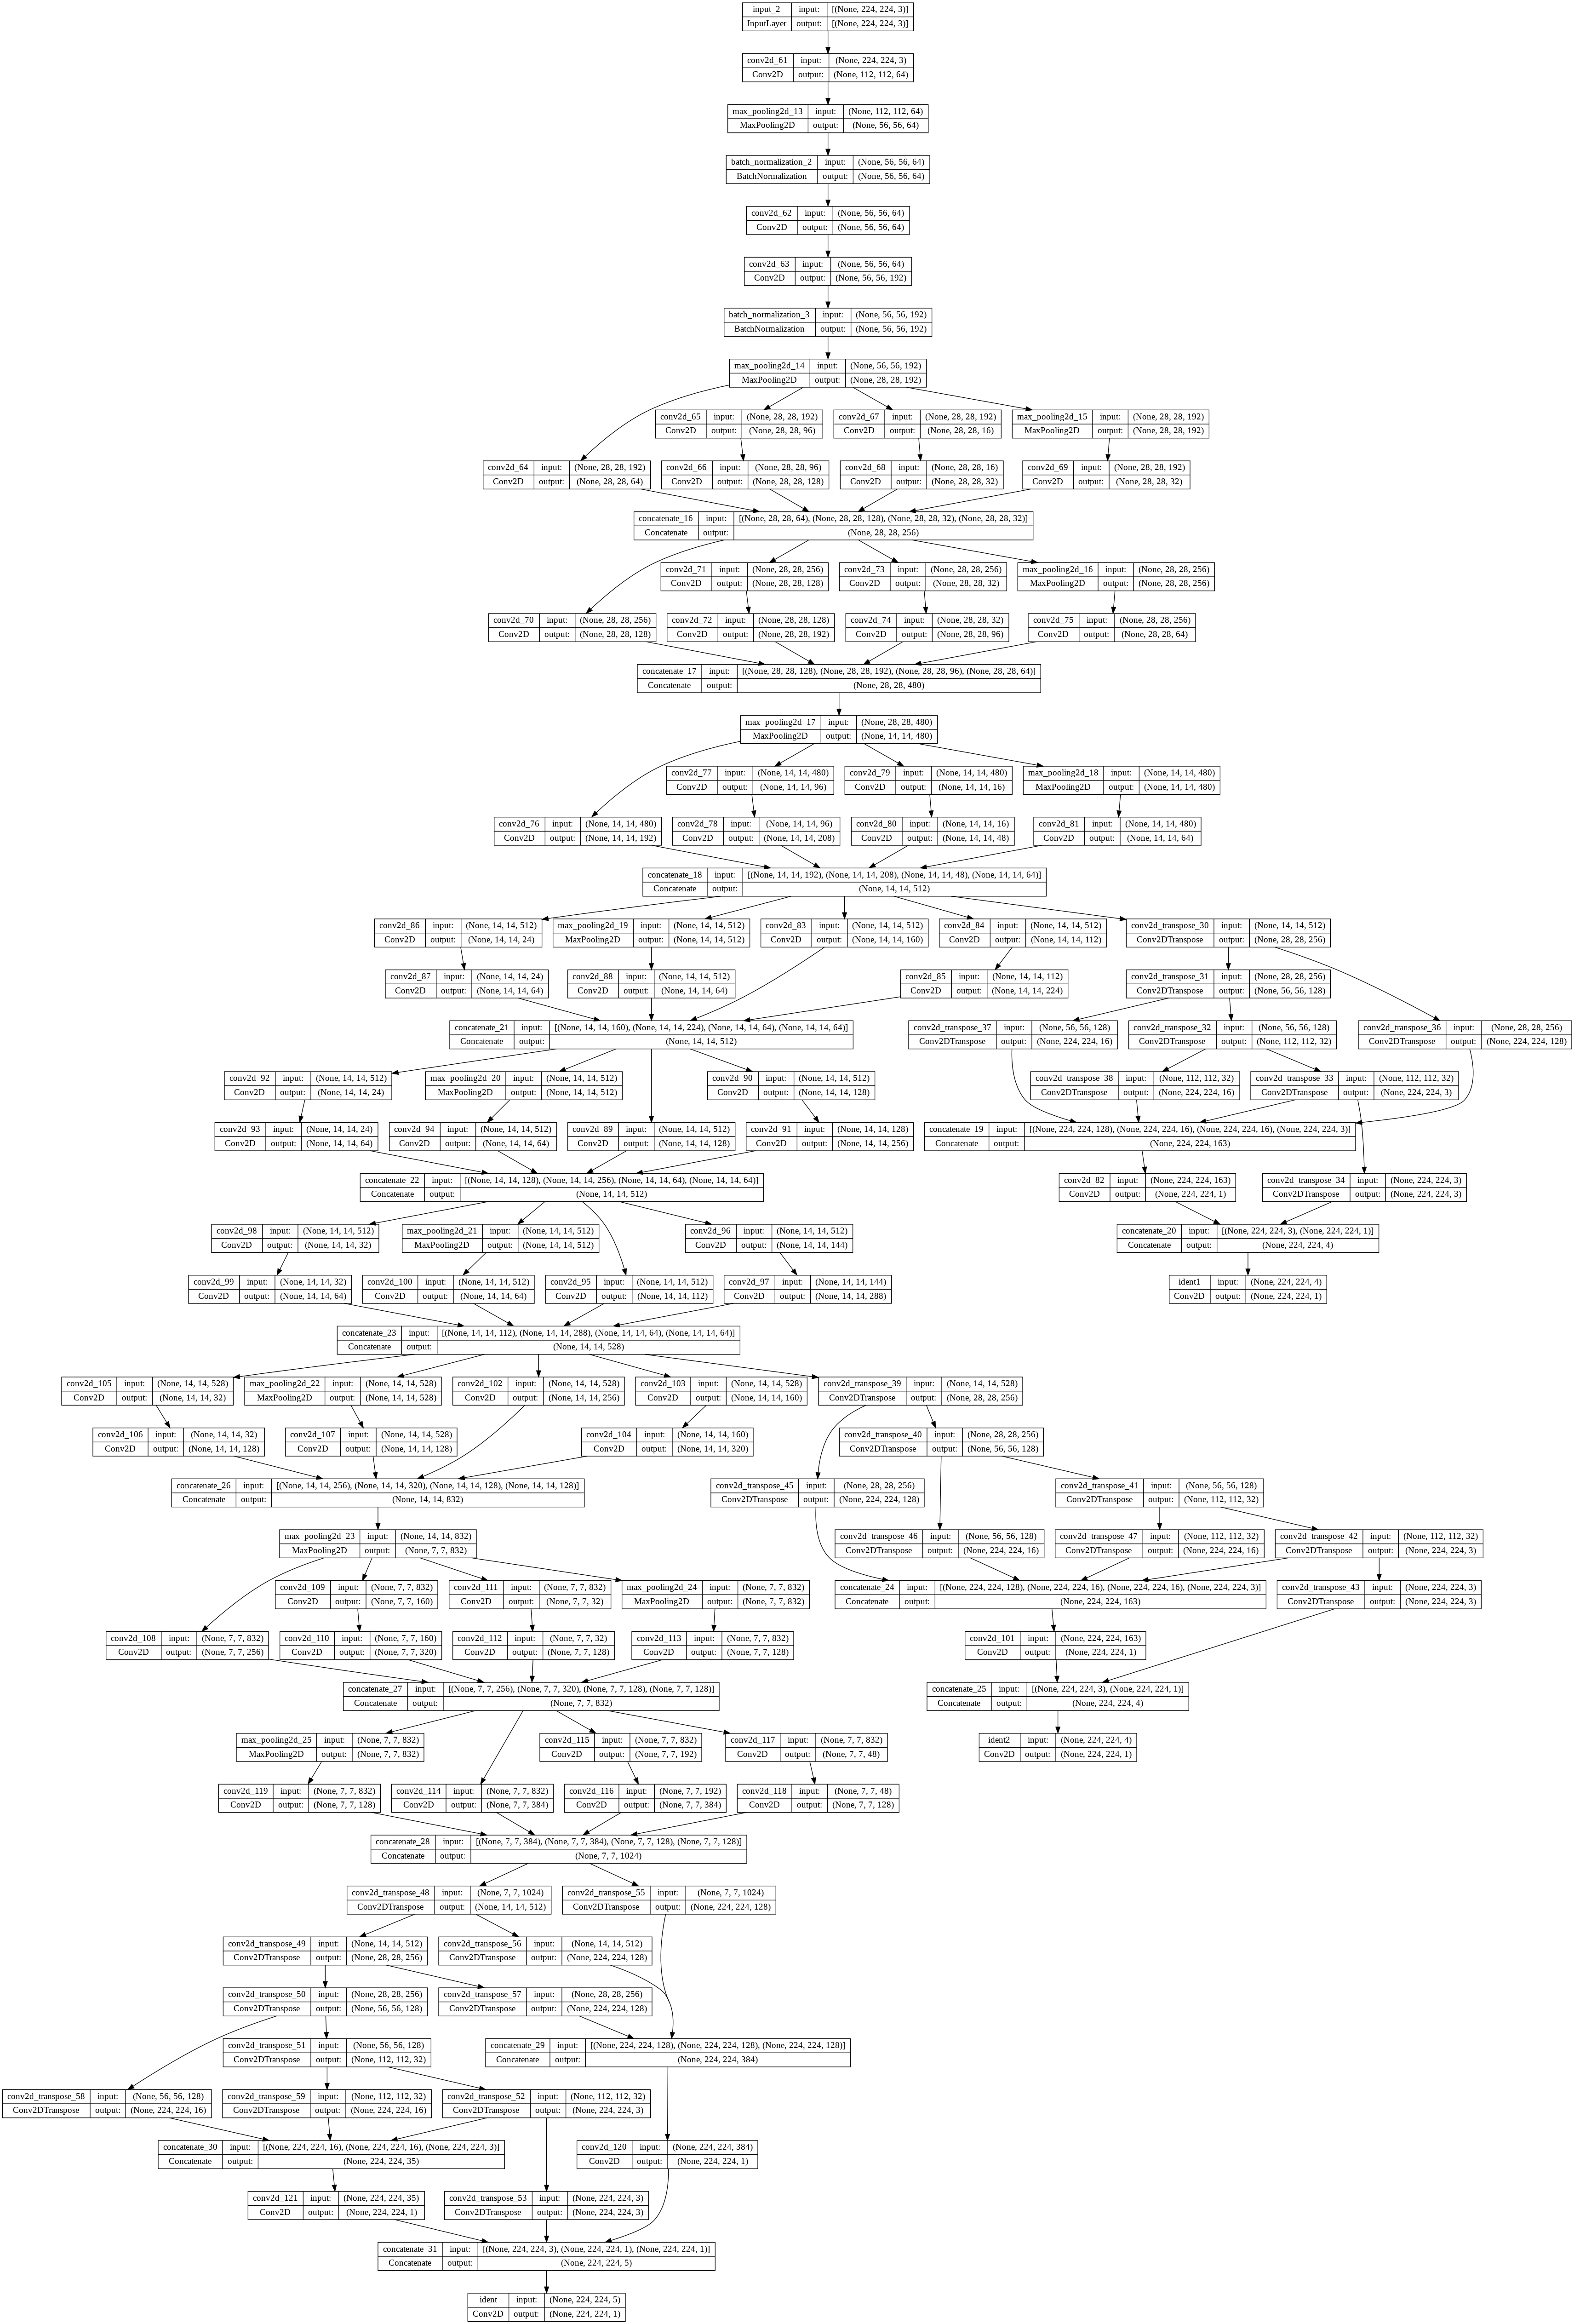

In [21]:
model = googlenet()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#model.summary()

In [65]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["ident_accuracy"]
        if accuracy > self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.99)]

In [24]:
x_train = total_images[:800].astype(np.float32)/ 255.0
y_train=total_labels[:800].astype(np.float32)/ 255.0
y_train=np.where(y_train>0.5,1.0,0.0)
y_train=(y_train)

In [27]:
(y_train[0]).shape

(224, 224)

In [28]:
loss1="binary_crossentropy"
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss1,loss1],metrics=["accuracy"])

In [30]:
history = model.fit(x_train,[y_train,y_train,y_train], epochs=120,batch_size=20,validation_split=0.0,shuffle=True,callbacks=[callbacks])
model.save('sbdn_googlenet_exp1_chuk-dut_szu_model.h5')

Epoch 1/55
40/40 [==============================] - 45s 606ms/step - loss: 1.9414 - ident_loss: 0.6505 - ident1_loss: 0.6276 - ident2_loss: 0.6418 - ident_accuracy: 0.6340 - ident1_accuracy: 0.6347 - ident2_accuracy: 0.6242
Epoch 2/55
40/40 [==============================] - 24s 595ms/step - loss: 1.7506 - ident_loss: 0.5799 - ident1_loss: 0.5738 - ident2_loss: 0.5761 - ident_accuracy: 0.6684 - ident1_accuracy: 0.6417 - ident2_accuracy: 0.6521
Epoch 3/55
40/40 [==============================] - 24s 589ms/step - loss: 1.5834 - ident_loss: 0.5117 - ident1_loss: 0.5384 - ident2_loss: 0.5131 - ident_accuracy: 0.7480 - ident1_accuracy: 0.7436 - ident2_accuracy: 0.7457
Epoch 4/55
40/40 [==============================] - 24s 593ms/step - loss: 1.5439 - ident_loss: 0.4976 - ident1_loss: 0.5277 - ident2_loss: 0.4989 - ident_accuracy: 0.7578 - ident1_accuracy: 0.7555 - ident2_accuracy: 0.7590
Epoch 5/55
40/40 [==============================] - 24s 593ms/step - loss: 1.4928 - ident_loss: 0.4824 -

In [31]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'ident_loss', 'ident1_loss', 'ident2_loss', 'ident_accuracy', 'ident1_accuracy', 'ident2_accuracy'])


In [32]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-googlenet_chuk-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

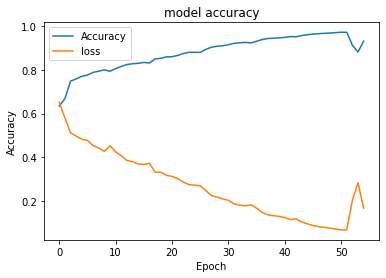

In [35]:
import matplotlib.pyplot as plt
plt.plot(history.history["ident_accuracy"])
plt.plot(history.history['ident_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","loss"])
plt.show()

In [36]:
eval_images=total_images[800:]
eval_labels=total_labels[800:]

In [37]:
eval_labels.shape

(200, 224, 224)

In [ ]:
from keras.models import load_model
from PIL import Image
images = eval_images
model = load_model("sbdn_googlenet_exp1_chuk-dut_szu_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [45]:
((predictions[0][1])[0]).shape

(224, 224, 1)

## Evaluation with Shi et al (Chuk) Dataset

In [41]:
ground_truth_total=eval_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)

In [46]:
pred_labels_total=[]
for i in range(len(predictions)):
  hh = ((predictions[i])[0])[0]
  hh = hh[:,:,0]
  pred_labels_total.append(hh)
pred_labels_total=np.array(pred_labels_total)

## Average IoU

In [49]:
def get_iou_score(true_label, y_pred_label):
  iou_scores=[]
  for i in range(0,len(true_label)):
    y_pred =np.where(y_pred_label[i]>0.5,1.0,0.0)
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label[i],y_pred)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)
iou_score= get_iou_score(ground_truth_total,pred_labels_total)
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.60967225


## Mean Absolute Error MAE

In [52]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    y_pred = np.where(y_pred_label[i]>0.5,1.0,0.0)
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,pred_labels_total)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.21773009008290814


## F-measure score

In [57]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(y_pred[i]>thr,1.0,0.0)
      #pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,pred_labels_total)

In [59]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('F-measure score: ',mean_Fb_score)

F-measure score:  0.8504638535780874


In [60]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.8723722602760458


predicted Blur Map for 100 test images from chuk


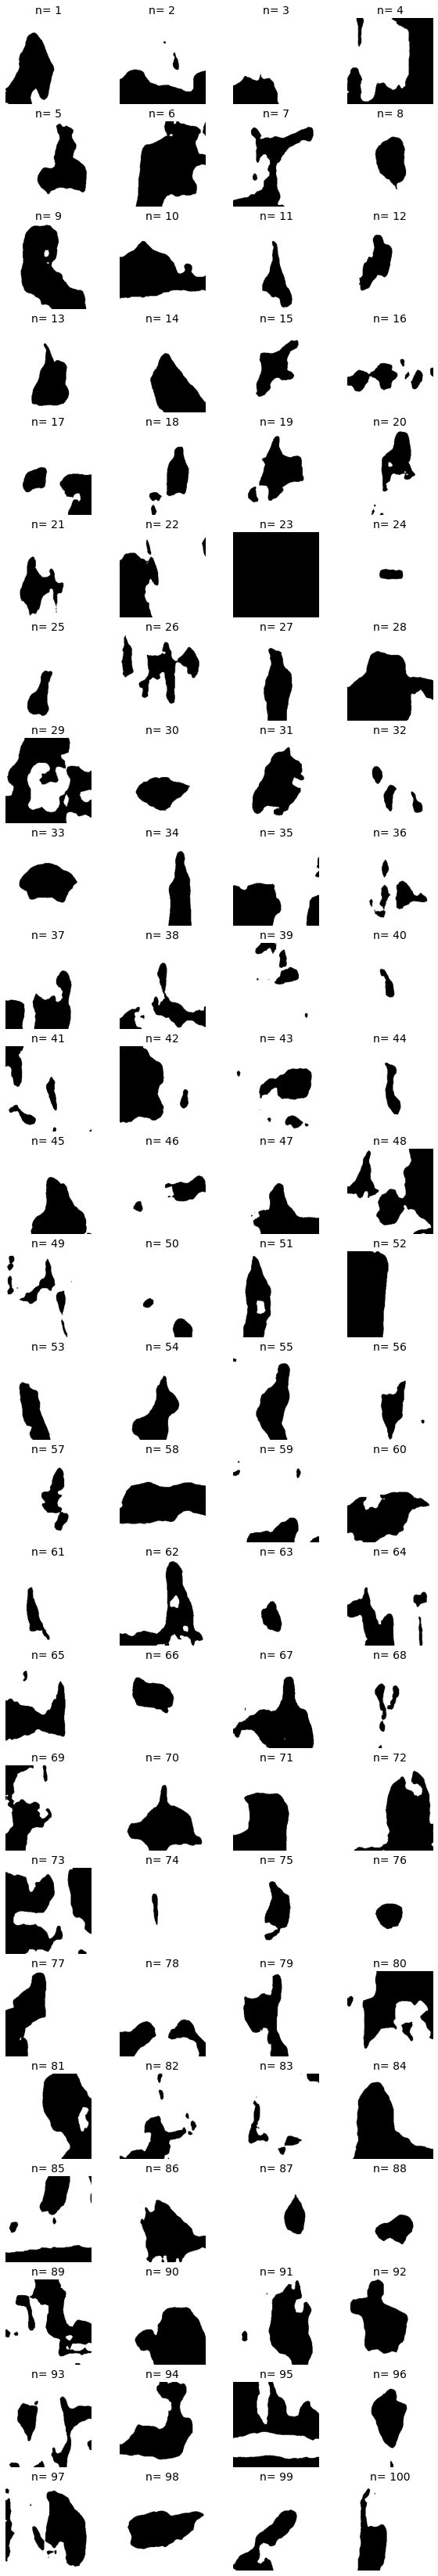

In [62]:
columns = 4
rows = 25
print("predicted Blur Map for 100 test images from chuk")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  plt.imshow(reshape(img_pred_label*255.0,[224,224]),cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

100 test images from CHUK 


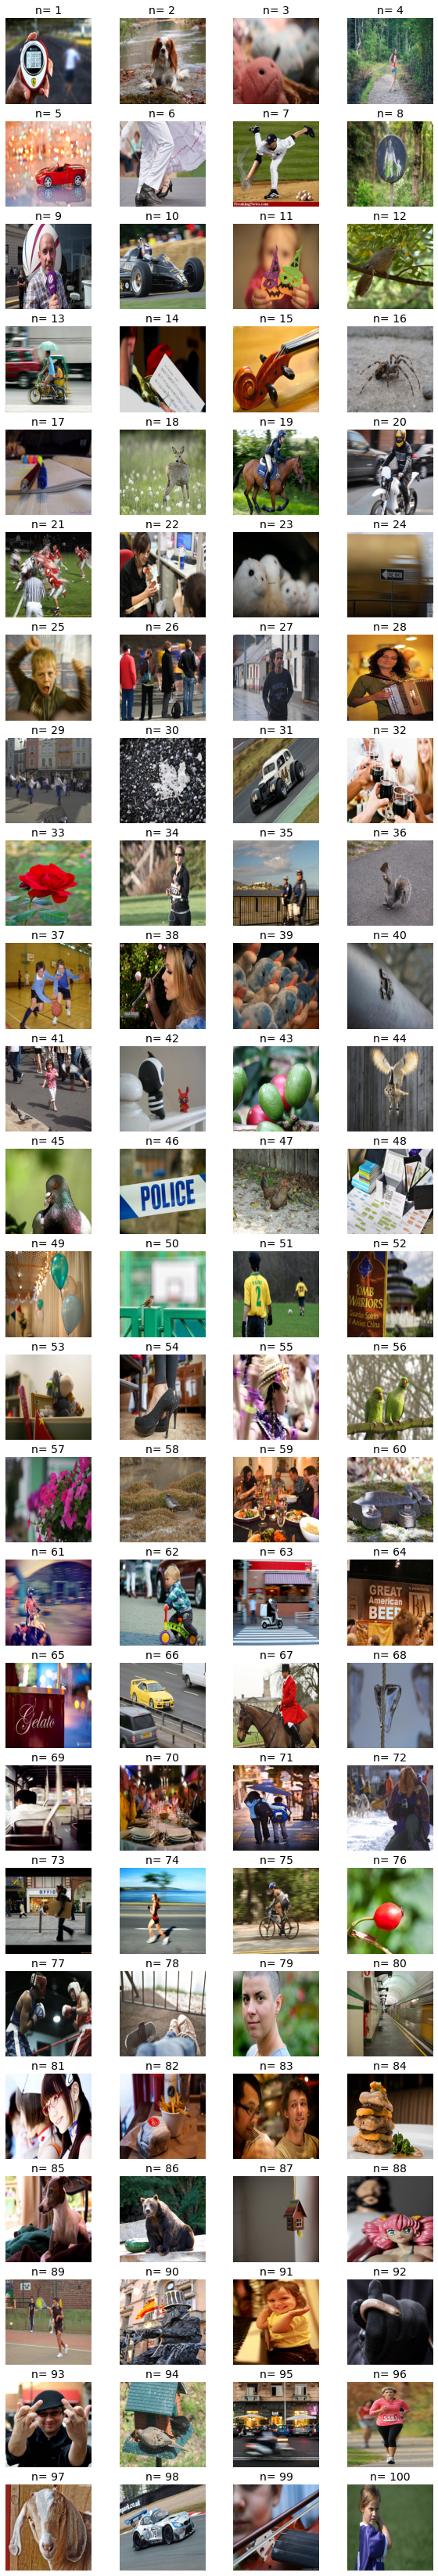

In [63]:
columns = 4
rows = 25
print("100 test images from CHUK ")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

GT of 100 images from CHUCK


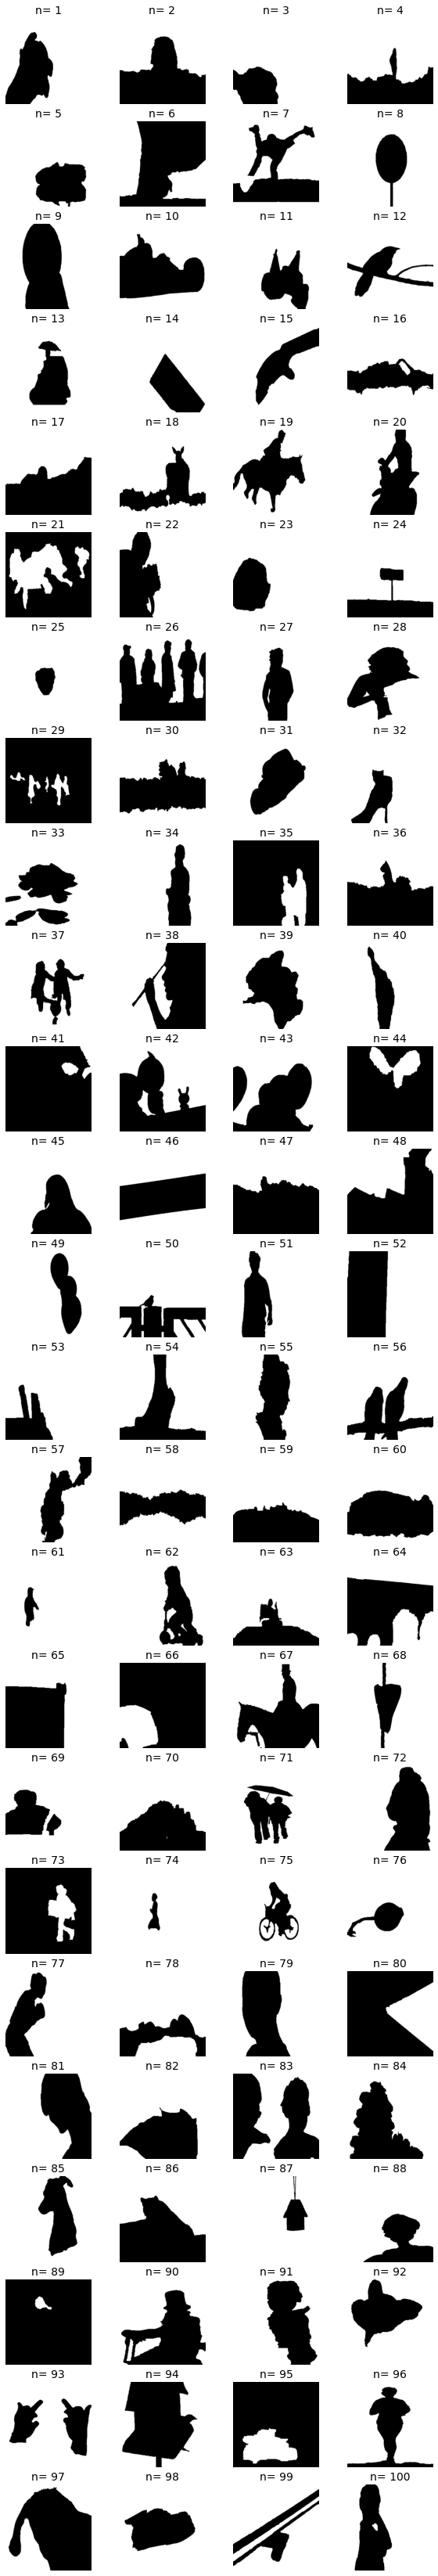

In [64]:
columns = 4
rows = 25
print("GT of 100 images from CHUCK")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i],cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

## Evaluation with DUT Dataset

In [66]:
!unzip -qq dut500-source.zip

In [67]:
!unzip -qq dut500-gt.zip

In [68]:
images_folder= "dut500-source/*.bmp"
labels_folder = "dut500-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      new_img = img.resize( (224, 224))
      image = array(new_img)
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [69]:
DUT_labels,DUT_images=data_preprocessing(images_folder,labels_folder)

In [70]:
DUT_images.shape

(500, 224, 224, 3)

In [71]:
DUT_labels.shape

(500, 224, 224)

In [ ]:
images = DUT_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [73]:
ground_truth_total=DUT_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,0.0,1.0)

In [74]:
pred_labels_total=[]
for i in range(len(predictions)):
  hh = ((predictions[i])[0])[0]
  hh = hh[:,:,0]
  pred_labels_total.append(hh)
pred_labels_total=np.array(pred_labels_total)

In [75]:
def get_mae(true_label, y_pred_label):
  absolute_error=[]
  for i in range(0,len(true_label)):
    y_pred = np.where(y_pred_label[i]>0.5,1.0,0.0)
    y_true=true_label[i]
    mae = tf.keras.losses.MeanAbsoluteError()
    m = mae(y_true, y_pred).numpy()
    absolute_error.append(m)
  return mean(absolute_error)
mean_absolute_error= get_mae(ground_truth_total,pred_labels_total)
print('Mean Absolute Error for Evaluation set: ',mean_absolute_error)

Mean Absolute Error for Evaluation set:  0.21800486288265306


## F-measure score

In [76]:
from sklearn.metrics import precision_score,recall_score
threshoulds=[0.3,0.4,0.5,0.6,0.7]
beta2=0.2
def recall_precison(y_true,y_pred):
  OIS_F=[]
  Fb=[]
  for i in range(0,len(y_pred)):
    OIS_F_thr=[]
    fb_thr=[]
    for thr in threshoulds:
      pr=np.where(y_pred[i]>thr,1.0,0.0)
      #pr=reshape(pr,[224,224])
      pred_precision_score=precision_score(y_true[i],pr, average='weighted')
      pred_recall_score=recall_score(y_true[i],pr, average='weighted')
      OIS=2*pred_precision_score*pred_recall_score/(pred_precision_score+pred_recall_score)
      fb=(1+beta2)*pred_precision_score*pred_recall_score/(beta2 * pred_precision_score+pred_recall_score)
      fb_thr.append(fb)
      OIS_F_thr.append(OIS)
    Fb.append(fb_thr)
    OIS_F.append(OIS_F_thr)
  return OIS_F,Fb

In [ ]:
OIS_array,Fb_array=recall_precison(ground_truth_total,pred_labels_total)

In [78]:
def Fb_score(Fb_array):
  best_Fb=[]
  for results in Fb_array:
    f_score=max(results)
    best_Fb.append(f_score)
  return np.nanmean(best_Fb)
mean_Fb_score= Fb_score(Fb_array)
print('F-measure score: ',mean_Fb_score)

F-measure score:  0.8629579390038316


In [79]:
def OIS_F_score(OIS_array):
  best_OIS_F=[]
  index_max=[]
  for results in OIS_array:
    f_score=max(results)
    best_OIS_F.append(f_score)
    index = results.index(f_score)
    index_max.append(index)
  return best_OIS_F,index_max
OIS_f1,indexes=OIS_F_score(OIS_array)
print('Average Optimal Image Scale F score: ',np.nanmean(OIS_f1))

Average Optimal Image Scale F score:  0.8952161447579151


predicted Blur Map for 100 test images from DUT


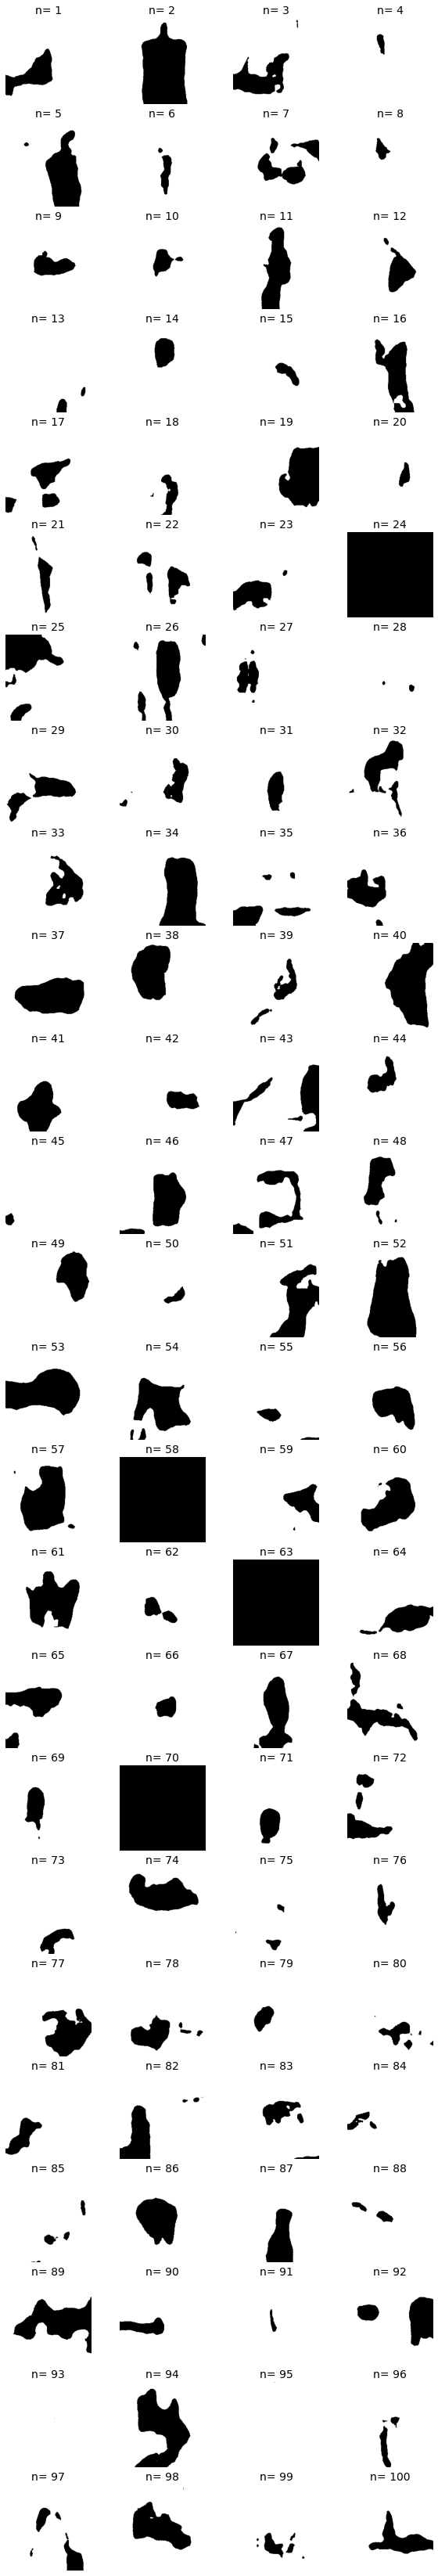

In [80]:
columns = 4
rows = 25
print("predicted Blur Map for 100 test images from DUT")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  plt.imshow(reshape(img_pred_label*255.0,[224,224]),cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

100 test images from DUT 


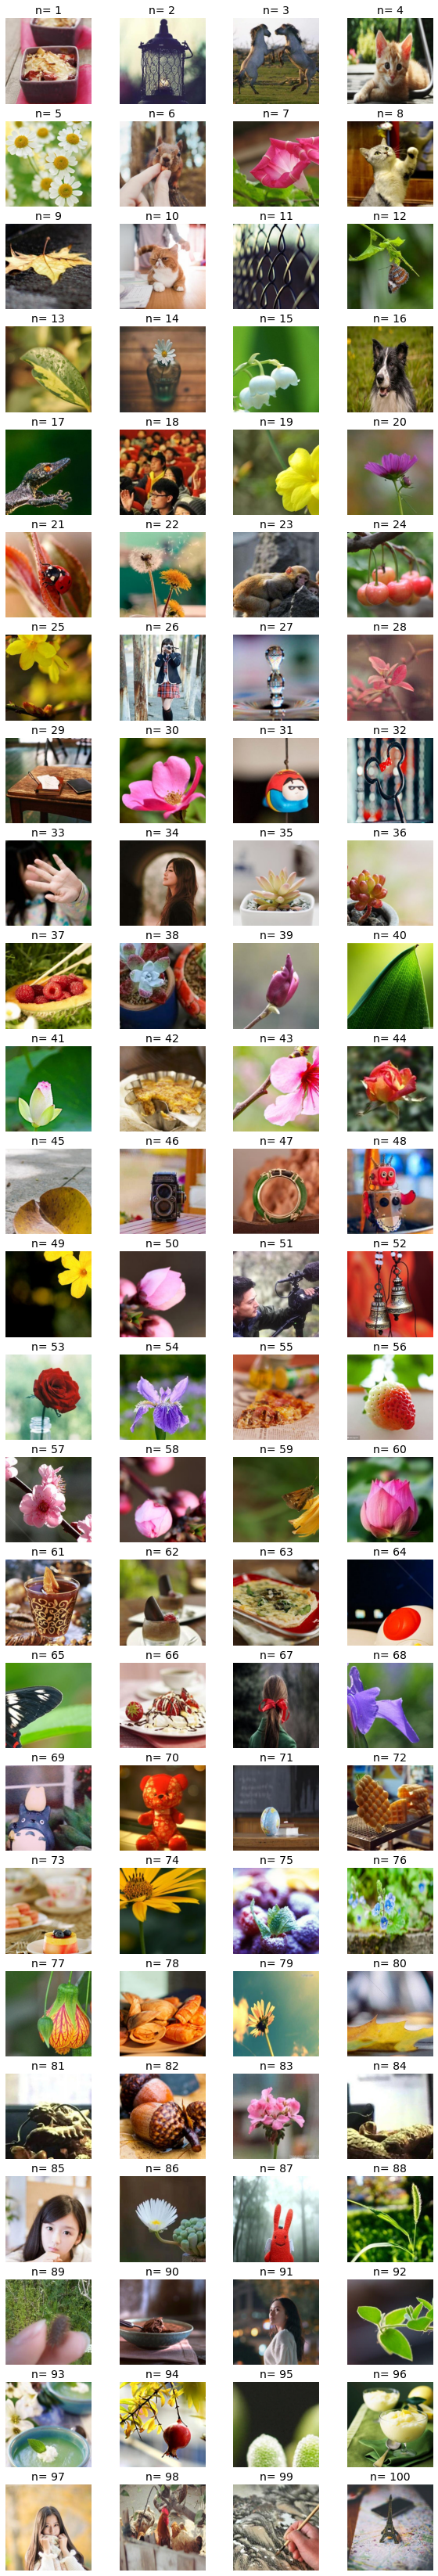

In [82]:
columns = 4
rows = 25
print("100 test images from DUT ")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

GT of 100 images from DUT


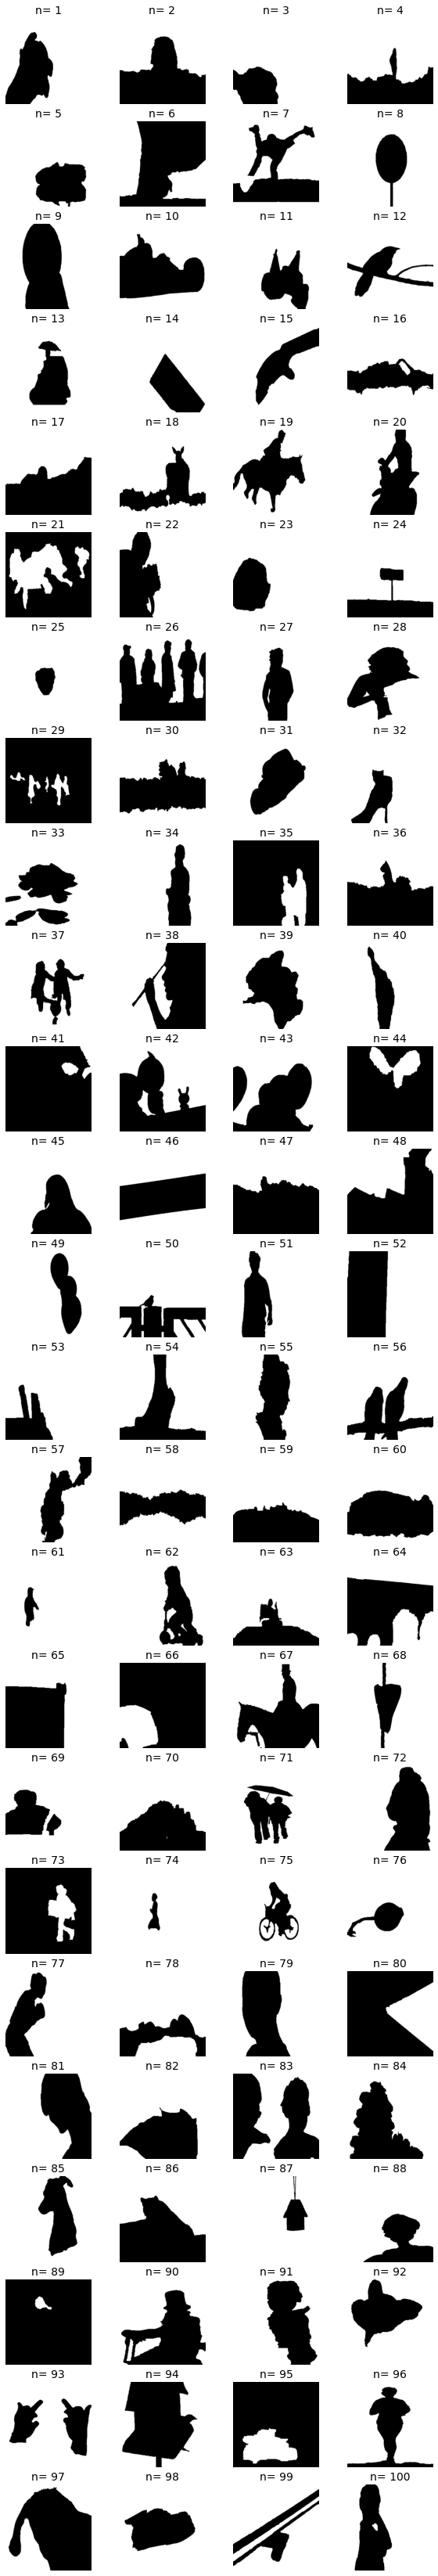

In [83]:
columns = 4
rows = 25
print("GT of 100 images from DUT")
fig = plt.figure(figsize=(10,60))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i],cmap='gray')
  plt.title(f"n= {i+1}",fontsize=14)
  plt.axis("off")
plt.show()

## Evaluation with SZU-DB Dataset

In [ ]:
!unzip -qq SZU-img.zip

In [ ]:
!unzip -qq SZU-gt.zip

In [ ]:
from numpy import *
images_folder= "SZU-img/*.jpg"
labels_folder = "SZU-gt/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  label = []
  files = glob.glob (images_folder)
  for myFile in files:
      image_name=os.path.split(myFile)[1]
      img = Image.open(myFile)
      img = img.resize( (224, 224))
      image= np.asarray(img)
      image_name=image_name[:-3]
      image_name=image_name+'png'
      new_label=Image.open(labels_folder+image_name)
      new_label = new_label.resize((224, 224))
      label_image = array(new_label)
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return label,total_img

In [ ]:
SZU_labels,SZU_images=data_preprocessing(images_folder,labels_folder)

In [ ]:
SZU_images.shape

In [ ]:
SZU_labels.shape

In [ ]:
images = SZU_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [ ]:
ground_truth_total=SZU_labels/255.0
ground_truth_total=np.where(ground_truth_total>0.5,1.0,0.0)